In [1]:
%env CUDA_VISIBLE_DEVICES=6
%env OMP_NUM_THREADS=2

env: CUDA_VISIBLE_DEVICES=6
env: OMP_NUM_THREADS=2


In [3]:
import sys
import os

sys.path.extend(['/home/jorg/repo/SuperResolution_aniso_MRI'])
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm

import numpy as np
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import SimpleITK as sitk
try:
    from skimage.measure import compare_ssim as ssim_metric
    from skimage.measure import compare_psnr as psnr_metric
except ImportError:
    from skimage.metrics import structural_similarity as ssim_metric
    from skimage.metrics import peak_signal_noise_ratio as psnr_metric

from datasets.data_config import get_config
from datasets.shared_transforms import CenterCrop, AdjustToPatchSize
from kwatsch.get_trainer import get_trainer
from evaluate.create_HR_images import create_hr_images
from datasets.cardiac_image import get_cardiac4d_per_frame
from datasets.ACDC.data import acdc_all_image4d
from datasets.ACDC.data4d_simple import get_patids_acdc_sr
from evaluate.cardiac.evaluate_model import create_cardiac_volumes
from evaluate.cardiac.evaluate_model import create_acdc_volumes_conventional_interpolation
%matplotlib inline
%load_ext autoreload
%autoreload 2

torch.manual_seed(32563)
rs = np.random.RandomState(32563)


print("Ready")

Ready


## Generate ACDC volumes with Autoencoder approach

In [4]:
pat_nums_training = get_patids_acdc_sr("training", rs=rs, limited_load=False)
pat_nums_training.sort()
pat_nums_validation = get_patids_acdc_sr("validation", rs=rs, limited_load=False)
pat_nums_validation.sort()
pat_nums_test = get_patids_acdc_sr("test", rs=rs, limited_load=False)
pat_nums_test.sort()
pat_all = pat_nums_training + pat_nums_validation

In [9]:
pat_nums = get_patids_acdc_sr("test", rs=rs, limited_load=False)
pat_nums.sort()
exper_src_path = "~/expers/sr/ACDC/ae_combined/mse_perc_p32_l128_aug180_w007_ex01"
model_nbr = 419  # 885
save_metrics = False
# ADJUST !!! CHECK !!! ESPECIALLY RESAMPLE !!!
output_dir = None  # exper_src_path + os.sep + "ni06"  # None
resample = True   # resample back to original pixel spacing in-plane (1.4^2 for ae)
# ADJUST !!   END   END
eval_axis = 0
do_save = False
eval_patch_size = 224  
generate_inbetween_slices = True
use_original_slice = False
downsample_steps = 2
num_interpolations = downsample_steps - 1
if not generate_inbetween_slices:
    downsample_steps = None
    num_interpolations = 6
    output_dir = exper_src_path + os.sep + "ni0{}".format(num_interpolations)
metrics_dict = create_cardiac_volumes(exper_src_path, model_nbr, 
                                      [78, 90], # pat_nums_test,
                                   dataset_name='ACDC',
                                   eval_patch_size=eval_patch_size, save_volumes=do_save, 
                                   generate_inbetween_slices=generate_inbetween_slices,
                                   downsample_steps=downsample_steps, 
                                   num_interpolations=num_interpolations,
                                   compute_percept_loss=False, 
                                   use_original_slice=use_original_slice,
                                   eval_axis=eval_axis, model_nbr_sr=None, 
                                   resample=resample, output_dir=output_dir, 
                                  save_metrics=save_metrics)

INFO - evaluating on ACDC dataset with 2 patients
INFO - Initializing trainer AETrainerEndToEnd - using multiple gpus False
Warning - Base Trainer - LPIPS on GPU-ID 0
Warning - LPIPS weights [1.0, 1.0, 1.0, 1.0, 1.0] 
Loading model from: /home/jorg/repo/SuperResolution_aniso_MRI/lpips/weights/v0.1/vgg.pth
INFO - AETrainerEndToEnd Loaded model parameters from /home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p32_l128_aug180_w007_ex01/models/419.models
WARNING WARNING - you are using VanillaACAI CAE class
WARNING - ACDC - Current model-nbr >>> 419 <<< train patch-size/test patch-size 128/224
{'ae_class': 'VanillaACAI', 'alpha_class': None, 'alpha_dims': None, 'alpha_loss_func': None, 'aug_patch_size': 180, 'batch_size': 12, 'colors': 1, 'comment': None, 'dataset': 'ACDC', 'depth': 32, 'device': 'cuda', 'dir_images': '/home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p32_l128_aug180_w007_ex01/log_images', 'dir_models': '/home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p32_l128_aug180_w007_ex01/mo

## Generate ACDC volumes with conventional methods

In [ ]:

interpol_filter = "linear"  #   bspline  lanczos, linear nearest
downsample_steps = 2
generate_inbetween_slices = True
eval_patch_size = 224 # 224
eval_axis = 1
num_interpolations = 1
expand_factor = 2
save_volumes = True
dataset = 'sunnybrook'   # 'ACDC'
output_dir = '~/expers/sr/{}/conventional'.format(dataset)
if not generate_inbetween_slices:
    downsample_steps = None
    expand_factor = 10
    num_interpolations = expand_factor - 1
    
for interpol_filter in ['linear',  'bspline', 'lanczos']:
    metrics_dict = create_acdc_volumes_conventional_interpolation(interpol_filter, 
                                                                 None, # pat_nums_test,  
                                                              expand_factor=expand_factor,
                                                   dataset_name=dataset,
                                                   eval_patch_size=eval_patch_size, 
                                                    save_volumes=save_volumes, 
                                                   downsample_steps=downsample_steps,
                                                   compute_percept_loss=False,
                                                   use_original_slice=False, 
                                                   generate_inbetween_slices=generate_inbetween_slices,
                                                   num_interpolations=num_interpolations,
                                                   output_dir=output_dir, eval_axis=eval_axis)

INFO - evaluating on sunnybrook dataset for test volumes
WARNING - Creating volumes with conventional interpolation method linear - eval-patch-size 224 - expand factor 2 - downsample steps 2 
INFO - saving output to /home/jorg/expers/sr/sunnybrook/conventional/linear
INFO - saved /home/jorg/expers/sr/sunnybrook/conventional/linear/SC-HF-NI-04/SC-HF-NI-04_ni01.nii.gz
SSIM / PSRN / VIF: 0.827 / 22.748 / 0.864
INFO - saved /home/jorg/expers/sr/sunnybrook/conventional/linear/SC-HYP-40/SC-HYP-40_ni01.nii.gz
SSIM / PSRN / VIF: 0.846 / 24.393 / 0.868
INFO - saved /home/jorg/expers/sr/sunnybrook/conventional/linear/SC-HF-I-01/SC-HF-I-01_ni01.nii.gz
SSIM / PSRN / VIF: 0.838 / 23.983 / 0.861
INFO - saved /home/jorg/expers/sr/sunnybrook/conventional/linear/SC-HF-NI-14/SC-HF-NI-14_ni01.nii.gz
SSIM / PSRN / VIF: 0.878 / 25.155 / 0.877
INFO - saved /home/jorg/expers/sr/sunnybrook/conventional/linear/SC-HF-I-08/SC-HF-I-08_ni01.nii.gz
SSIM / PSRN / VIF: 0.863 / 23.920 / 0.865
INFO - saved /home/jorg/e

INFO - saved /home/jorg/expers/sr/sunnybrook/conventional/bspline/SC-HF-I-09/SC-HF-I-09_ni01.nii.gz
SSIM / PSRN / VIF: 0.806 / 22.068 / 0.868
INFO - saved /home/jorg/expers/sr/sunnybrook/conventional/bspline/SC-HF-I-11/SC-HF-I-11_ni01.nii.gz
SSIM / PSRN / VIF: 0.808 / 21.340 / 0.862
INFO - saved /home/jorg/expers/sr/sunnybrook/conventional/bspline/SC-HF-I-07/SC-HF-I-07_ni01.nii.gz
SSIM / PSRN / VIF: 0.854 / 24.406 / 0.847
INFO - saved /home/jorg/expers/sr/sunnybrook/conventional/bspline/SC-HYP-06/SC-HYP-06_ni01.nii.gz
SSIM / PSRN / VIF: 0.898 / 30.600 / 0.868
INFO - saved /home/jorg/expers/sr/sunnybrook/conventional/bspline/SC-HYP-37/SC-HYP-37_ni01.nii.gz
SSIM / PSRN / VIF: 0.858 / 25.834 / 0.858
INFO - saved /home/jorg/expers/sr/sunnybrook/conventional/bspline/SC-HF-I-04/SC-HF-I-04_ni01.nii.gz
SSIM / PSRN / VIF: 0.841 / 22.591 / 0.865
INFO - saved /home/jorg/expers/sr/sunnybrook/conventional/bspline/SC-HF-I-10/SC-HF-I-10_ni01.nii.gz
SSIM / PSRN / VIF: 0.824 / 21.970 / 0.863
INFO - sav

INFO - saved /home/jorg/expers/sr/sunnybrook/conventional/lanczos/SC-HYP-03/SC-HYP-03_ni01.nii.gz
SSIM / PSRN / VIF: 0.790 / 21.023 / 0.837
INFO - saved /home/jorg/expers/sr/sunnybrook/conventional/lanczos/SC-HF-NI-31/SC-HF-NI-31_ni01.nii.gz
SSIM / PSRN / VIF: 0.855 / 24.718 / 0.859
INFO - saved /home/jorg/expers/sr/sunnybrook/conventional/lanczos/SC-HF-I-12/SC-HF-I-12_ni01.nii.gz
SSIM / PSRN / VIF: 0.842 / 23.372 / 0.856
INFO - saved /home/jorg/expers/sr/sunnybrook/conventional/lanczos/SC-N-06/SC-N-06_ni01.nii.gz
SSIM / PSRN / VIF: 0.869 / 27.218 / 0.857
INFO - saved /home/jorg/expers/sr/sunnybrook/conventional/lanczos/SC-HYP-12/SC-HYP-12_ni01.nii.gz
SSIM / PSRN / VIF: 0.875 / 26.165 / 0.855
INFO - saved /home/jorg/expers/sr/sunnybrook/conventional/lanczos/SC-HF-NI-07/SC-HF-NI-07_ni01.nii.gz
SSIM / PSRN / VIF: 0.819 / 21.983 / 0.853
INFO - saved /home/jorg/expers/sr/sunnybrook/conventional/lanczos/SC-N-05/SC-N-05_ni01.nii.gz
SSIM / PSRN / VIF: 0.875 / 26.174 / 0.867
INFO - saved /home

## Create SR volumes for subset Sunnybrook dataset

In [5]:
model_nbr = 419 # 777  #
model_nbr_sr =  None
# mse_baseline_p32_l128_ex01 (885)  mse_perc_p16_l128_w007_ex01 (862)
exper_src_path = "~/expers/sr/ACDC/ae_combined/mse_perc_p32_l128_aug180_w007_ex01"
output_dir = "/home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p32_l128_aug180_w007_ex01/sunnybrook"
do_save = True
do_resample = True
eval_patch_size = 224  # 224  
generate_inbetween_slices = True
eval_axis = 1
use_original_slice = False   
downsample_steps = 2
num_interpolations = downsample_steps - 1
if not generate_inbetween_slices:
    downsample_steps = None
    num_interpolations = 6
metrics_dict = create_acdc_volumes(exper_src_path, model_nbr, None, 
                                   dataset_name='sunnybrook',
                                   eval_patch_size=eval_patch_size, save_volumes=do_save, 
                                   generate_inbetween_slices=generate_inbetween_slices,
                                   downsample_steps=downsample_steps, 
                                   num_interpolations=num_interpolations,
                                   compute_percept_loss=False, 
                                   use_original_slice=use_original_slice,
                                  output_dir=output_dir, eval_axis=eval_axis,
                                   resample=do_resample,
                                  model_nbr_sr=model_nbr_sr)


INFO - evaluating on sunnybrook dataset for test volumes
INFO - Initializing trainer AETrainerEndToEnd - using multiple gpus False
Warning - Base Trainer - LPIPS on GPU-ID 0
Warning - LPIPS weights [1.0, 1.0, 1.0, 1.0, 1.0] 
Loading model from: /home/jorg/repo/aesr/lpips/weights/v0.1/vgg.pth
INFO - AETrainerEndToEnd Loaded model parameters from /home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p32_l128_aug180_w007_ex01/models/419.models
WARNING WARNING - you are using VanillaACAI CAE class
WARNING - sunnybrook - Current model-nbr >>> 419 <<< train patch-size/test patch-size 128/224
{'ae_class': 'VanillaACAI', 'alpha_class': None, 'alpha_dims': None, 'alpha_loss_func': None, 'aug_patch_size': 180, 'batch_size': 12, 'colors': 1, 'comment': None, 'dataset': 'ACDC', 'depth': 32, 'device': 'cuda', 'dir_images': '/home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p32_l128_aug180_w007_ex01/log_images', 'dir_models': '/home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p32_l128_aug180_w007_ex01/models', '

Create hr images - resampled IMAGE - original/new spacing  (8, 1.25, 1.25) [8.   1.25 1.25]
INFO - saved /home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p32_l128_aug180_w007_ex01/sunnybrook/images_sr_ip/SC-HF-I-10/SC-HF-I-10_ni01.nii.gz
SSIM / PSRN / VIF: 0.886 / 25.075 / 0.859
Create hr images - resampled IMAGE - original/new spacing  (8, 1.25, 1.25) [8.   1.25 1.25]
INFO - saved /home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p32_l128_aug180_w007_ex01/sunnybrook/images_sr_ip/SC-N-05/SC-N-05_ni01.nii.gz
SSIM / PSRN / VIF: 0.912 / 29.329 / 0.888
Create hr images - resampled IMAGE - original/new spacing  (8, 1.25, 1.25) [8.   1.25 1.25]
INFO - saved /home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p32_l128_aug180_w007_ex01/sunnybrook/images_sr_ip/SC-HYP-03/SC-HYP-03_ni01.nii.gz
SSIM / PSRN / VIF: 0.834 / 23.010 / 0.854
Create hr images - resampled IMAGE - original/new spacing  (8, 1.25, 1.25) [8.   1.25 1.25]
INFO - saved /home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p32_l128_aug180_w007_e

In [ ]:
Sunnybrook 45 patients/2 phases: patch-size 224^2 / 140^2
AE
Results - SSIM / PSRN / VIF / LPIPS: 0.893 (0.02) / 25.76 (1.98) / 0.871 (0.01) / 0.000 (0.00)
Results - SSIM / PSRN / VIF / LPIPS: 0.855 (0.03) / 24.10 (2.44) / 0.870 (0.02) / 0.000 (0.00)
CAISR
Results - SSIM / PSRN / VIF / LPIPS: 0.866 (0.02) / 26.15 (1.78) / 0.871 (0.01) / 0.000 (0.00)
Results - SSIM / PSRN / VIF / LPIPS: 0.865 (0.03) / 24.80 (2.33) / 0.860 (0.02) / 0.000 (0.00)
Linear
Results - SSIM / PSRN / VIF / LPIPS: 0.858 (0.03) / 23.86 (1.51) / 0.860 (0.01) / 0.000 (0.00)
Results - SSIM / PSRN / VIF / LPIPS: 0.800 (0.04) / 22.59 (2.23) / 0.853 (0.01) / 0.000 (0.00)
B-spline
Results - SSIM / PSRN / VIF / LPIPS: 0.850 (0.03) / 25.16 (1.49) / 0.849 (0.01) / 0.000 (0.00)
Results - SSIM / PSRN / VIF / LPIPS: 0.798 (0.04) / 22.36 (2.21) / 0.853 (0.01) / 0.000 (0.00)  
Lanczos
Results - SSIM / PSRN / VIF / LPIPS: 0.841 (0.04) / 24.67 (1.52) / 0.846 (0.01) / 0.000 (0.00)
Results - SSIM / PSRN / VIF / LPIPS: 0.797 (0.04) / 22.22 (2.25) / 0.851 (0.01) / 0.000 (0.00)    

## Create SR volumes for subset ARVC dataset

In [4]:
model_nbr = 862 # 777  #
model_nbr_sr =  None# 836
exper_src_path = "~/expers/sr/ACDC/ae_combined/mse_perc_p16_l128_w007_ex01"
output_dir = "/home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p16_l128_w007_ex01/PIE"
do_save = True
dataset_name = 'PIE'
resample = False
# ADJUST !!   END   END
eval_axis = 1
eval_patch_size = 224  
generate_inbetween_slices = False
use_original_slice = False
downsample_steps = 2
num_interpolations = downsample_steps - 1
if not generate_inbetween_slices:
    downsample_steps = None
    num_interpolations = 7
    output_dir = output_dir + os.sep + "ni0{}".format(num_interpolations)
metrics_dict = create_acdc_volumes(exper_src_path, model_nbr, None, 
                                   dataset_name=dataset_name,
                                   eval_patch_size=eval_patch_size, save_volumes=do_save, 
                                   generate_inbetween_slices=generate_inbetween_slices,
                                   downsample_steps=downsample_steps, 
                                   num_interpolations=num_interpolations,
                                   compute_percept_loss=False, 
                                   use_original_slice=use_original_slice,
                                  output_dir=output_dir, eval_axis=eval_axis,
                                  model_nbr_sr=model_nbr_sr,
                                  resample=resample)

INFO - evaluating on PIE dataset: /home/jorg/data/cardiac_pie/nifti/sax
INFO - Initializing trainer AETrainerEndToEnd - using multiple gpus False
Warning - LPIPS weights [1.0, 1.0, 1.0, 1.0, 1.0] 
Loading model from: /home/jorg/repo/aesr/lpips/weights/v0.1/vgg.pth
INFO - AETrainerEndToEnd Loaded model parameters from /home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p16_l128_w007_ex01/models/862.models
WARNING WARNING - you are using VanillaACAI CAE class
WARNING - PIE - Current model-nbr >>> 862 <<< train patch-size/test patch-size 64/224
INFO - Using no TRANSFORM. Resample back to original spacing: False
{'ae_class': 'VanillaACAI', 'alpha_class': None, 'alpha_dims': None, 'alpha_loss_func': None, 'aug_patch_size': 140, 'batch_size': 12, 'colors': 1, 'comment': None, 'dataset': 'ACDC', 'depth': 32, 'device': 'cuda', 'dir_images': '/home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p16_l128_w007_ex01/log_images', 'dir_models': '/home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p16_l128_w007_ex01

In [14]:
f = "/home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p16_l128_w007_ex01/arvc/ni07/images_sr_ip/30010_0/"
f += "30010_0_ni07_oslices.nii.gz"
print(f)
img = sitk.ReadImage(f)
print(img.GetSpacing(), img.GetSize())


/home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p16_l128_w007_ex01/arvc/ni07/images_sr_ip/30010_0/30010_0_ni07_oslices.nii.gz
(1.25, 1.25, 1.0, 1.0) (256, 256, 113, 30)


In [21]:
from datasets.ARVC.common import get_abs_filenames_segmentation

arvc_pat_dict = get_abs_filenames_segmentation()
print(len(arvc_pat_dict['test']))

INFO - get_patient_ids_segmentation - Get split file from /home/jorg/repo/seg_uncertainty/datasets/ARVC/train_test_split_seg.yaml
154


In [4]:
from utils.base_trainer import BaseTrainer, show_loss_curves

path_to_exper = "~/expers/sr/OASIS/ae_combined/mse_perc_p16_l128_3mm_w003_ex01"
iters, losses_train, losses_test = BaseTrainer.load_losses(path_to_exper)

In [5]:
loss_key = "loss_ae_dist"

idx_last = np.arange(len(iters) - 10, len(iters))
print("last ae ", losses_test[loss_key][idx_last])
print("last ae-extra ", losses_test['loss_ae_dist_extra'][idx_last])
idx_min = np.argmin(losses_test[loss_key][1:]) + 1
idx_min_ex = np.argmin(losses_test['loss_ae_dist_extra'][1:]) + 1
min_range = np.arange(idx_min - 5, idx_min + 5)
print("best {}: ".format(loss_key), iters[idx_min], losses_test[loss_key][idx_min])
print("for extra :", iters[idx_min], losses_test['loss_ae_dist_extra'][idx_min])
print("best extra: ", iters[idx_min_ex], losses_test['loss_ae_dist_extra'][idx_min_ex])
print("for {}: ".format(loss_key), iters[idx_min_ex], losses_test[loss_key][idx_min_ex])
# print("around best ", losses_test[loss_key][min_range])
# print("iters around best ", iters[min_range])
print(losses_test[loss_key][777], losses_test['loss_ae_dist_extra'][838])

last ae  [9.85918887e-05 9.86476880e-05 1.01360903e-04 1.32176865e-04
 1.09518242e-04 9.33132687e-05 1.50882879e-04 9.94051879e-05
 9.68414352e-05 1.11647350e-04]
last ae-extra  [0.00222043 0.00225568 0.00225296 0.00225212 0.00222821 0.00221624
 0.00221728 0.002228   0.00221642 0.00220746]
best loss_ae_dist:  1121603 8.888091178960167e-05
for extra : 1121603 0.0022311366628855467
best extra:  1179600 0.0022074594162404537
for loss_ae_dist:  1179600 0.00011164735042257234
0.00013582969404524192 0.0025954744778573513


In [37]:
best loss_ae_dist:  1862500 2.2901176635059528e-05
for extra : 1862500 7.16677459422499e-05
best extra:  1886500 7.001564517850056e-05
for loss_ae_dist:  1886500 2.697386298677884e-05
4.9316724471282214e-05 9.185606904793531e-05

1.524297442334486
1.4999999999999998


2792 dict_keys(['loss_ae_dist', 'loss_ae_extra', 'loss_ae_dist_extra', 'loss_ae', 'loss_latent_1'])


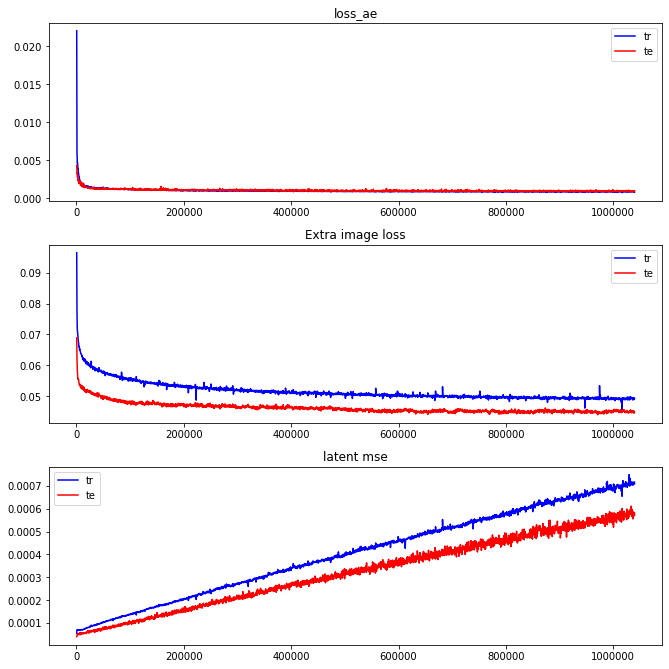

In [120]:
print(len(iters), losses_train.keys())

e_range = None # slice(len(iters) - 100, len(iters), None)
show_loss_curves(iters, losses_train, losses_test, e_range)

## Move files

In [9]:
from pathlib import Path
import shutil

file_suffix = "*_ni07_oslices.nii.gz"
mydir = "/home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p16_l128_w007_ex01/arvc/ni07/"
target_dir = "/home/jorg/data/ARVC/nifti/sax_sr/"
if not os.path.isdir(target_dir):
    os.makedirs(target_dir, exist_ok=False)
filepath_generator = Path(mydir).rglob(file_suffix)
filepath_list = [file_obj for file_obj in filepath_generator]
print("Moving {} files".format(len(filepath_list)))
for fname in filepath_list:
    fname_base = os.path.basename(fname).replace("_oslices", "")
    target_fname = os.path.join(target_dir, fname_base)
    print(fname, target_fname)
    shutil.move(fname, target_fname)


Moving 157 files
/home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p16_l128_w007_ex01/arvc/ni07/images_sr_ip/90081_0/90081_0_ni07_oslices.nii.gz /home/jorg/data/ARVC/nifti/sax_sr/90081_0_ni07.nii.gz
/home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p16_l128_w007_ex01/arvc/ni07/images_sr_ip/NLUTR69_4_0/NLUTR69_4_0_ni07_oslices.nii.gz /home/jorg/data/ARVC/nifti/sax_sr/NLUTR69_4_0_ni07.nii.gz
/home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p16_l128_w007_ex01/arvc/ni07/images_sr_ip/NLGRO4_2_2/NLGRO4_2_2_ni07_oslices.nii.gz /home/jorg/data/ARVC/nifti/sax_sr/NLGRO4_2_2_ni07.nii.gz
/home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p16_l128_w007_ex01/arvc/ni07/images_sr_ip/NLUTR30_17_1/NLUTR30_17_1_ni07_oslices.nii.gz /home/jorg/data/ARVC/nifti/sax_sr/NLUTR30_17_1_ni07.nii.gz
/home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p16_l128_w007_ex01/arvc/ni07/images_sr_ip/NLUTR73_1_1/NLUTR73_1_1_ni07_oslices.nii.gz /home/jorg/data/ARVC/nifti/sax_sr/NLUTR73_1_1_ni07.nii.gz
/home/jorg/expers/sr/ACDC/ae_combined/ms

In [68]:
f = "/home/jorg/data/sunnybrook/mhd/SC-N-10_ES.mhd"
print(sitk.GetArrayFromImage(sitk.ReadImage(f)).shape)

(12, 256, 256)


In [42]:
from evaluate.find_best_model import load_model_scores

file_suffix = "_axis0.npz"
synthesis = True
exper_dir = "~/expers/sr_redo/ACDC/ae_combined/pool2_w128_l128_w0_01_ex01"
results, iters, ssim_res, psnr_res, vif_res = \
            load_model_scores(exper_dir, file_suffix=file_suffix, 
                              synthesis=synthesis)

INFO - searching with mask /home/jorg/expers/sr_redo/ACDC/ae_combined/pool2_w128_l128_w0_01_ex01/model_perf_synth*_axis0.npz
INFO - loading /home/jorg/expers/sr_redo/ACDC/ae_combined/pool2_w128_l128_w0_01_ex01/model_perf_synth_200_to_900_axis0.npz


In [43]:
idx_psnr, idx_ssim, idx_vif = np.argmax(psnr_res), np.argmax(ssim_res), np.argmax(vif_res)
print("SSIM ({}): {:.3f}".format(iters[idx_ssim], ssim_res[idx_ssim]))
print("PSNR ({}): {:.3f}".format(iters[idx_psnr], psnr_res[idx_psnr]))
print("VIF ({}): {:.3f}".format(iters[idx_vif], vif_res[idx_vif]))
print("M-{}: {:.3f}, {:.3f}, {:.3f}".format(iters[idx_ssim], ssim_res[idx_ssim],
                                          psnr_res[idx_ssim], vif_res[idx_ssim]))
print("M-{}: {:.3f}, {:.3f}, {:.3f}".format(iters[idx_psnr], ssim_res[idx_psnr],
                                          psnr_res[idx_psnr], vif_res[idx_psnr]))
print("M-{}: {:.3f}, {:.3f}, {:.3f}".format(iters[idx_vif], ssim_res[idx_vif],
                                          psnr_res[idx_vif], vif_res[idx_vif]))

SSIM (791): 0.534
PSNR (608): 16.198
VIF (688): 0.803
M-791: 0.534, 16.144, 0.798
M-608: 0.526, 16.198, 0.801
M-688: 0.518, 16.139, 0.803


In [27]:
from datasets.ACDC.data4d_simple import get_4d_image_array, get_acdc_patient_sets

patient_sets = get_acdc_patient_sets()
pat_list = patient_sets['test']
transform140 = transforms.Compose([AdjustToPatchSize(tuple((140, 140))),
                                           CenterCrop(140)])
transform = transforms.Compose([AdjustToPatchSize(tuple((224, 224))),
                                           CenterCrop(224)])
image4d = get_4d_image_array("~/data/ACDC/all_cardiac_phases", rescale=True, resample=True, 
                             limited_load=False, new_spacing=tuple((1, 1.4, 1.4)),  
                             pat_nums=pat_list, transform=transform,
                             get_masks=False)

WARNING - get_4d_image_array - Loading ACDC data from /home/jorg/data/ACDC/all_cardiac_phases


Loading 20 patients:   0%|          | 0/20 [00:00<?, ?it/s]

WARNING - ACDC4D - skipping patient/frames patient015/(21-29)


In [86]:
from datasets.common import get_images_in_dir

EXPER_SRC_DIR = os.path.expanduser("~/expers/sr_redo/ACDC")
resample_inplane = True if 'sr_redo' in EXPER_SRC_DIR else False
file_suffix = "_ni01.nii.gz" 
exper_id = "ae_combined/pool2_w128_l128_w01_ex01"    # pool2_w128_l128_w0_01_ex01
path_method = os.path.join(EXPER_SRC_DIR, "{}/images_sr_ip".format(exper_id))
data_generator = get_images_in_dir(path_method, file_suffix=file_suffix, rescale_int=False, 
                                      do_downsample=False, downsample_steps=None, 
                                      patid_list=pat_list, resample_inplane=resample_inplane,
                                   new_spacing=tuple((1, 1.4, 1.4)))
print("Loaded from {} volumes from {} ({})".format(len(data_generator), exper_id,
                                                    file_suffix))

INFO - get_images_in_dir - dataset name ACDC. Resample-inplane True
Loaded from 20 volumes from ae_combined/pool2_w128_l128_w01_ex01 (_ni01.nii.gz)


In [87]:
from evaluate.quantitative_comparison import compare_quantitative

method = 'ae_combined'
method_dir = os.path.join(EXPER_SRC_DIR, exper_id)
downsample_steps = 2
eval_axis = 0
lpips = None # percept_criterion if eval_axis == 0 else None
do_save = True
result_dict = \
    compare_quantitative(image4d, data_generator, method, downsample_steps=downsample_steps, 
                         is_4d=True, do_save=do_save, method_dir=method_dir,
                         percept_criterion=lpips, 
                         transform=transform140, eval_axis=eval_axis)

INFO - evaluating ae_combined images from /home/jorg/expers/sr_redo/ACDC/ae_combined/pool2_w128_l128_w01_ex01
INFO - evaluation axis-0 - method: ae_combined - is conventional False - downsample steps 2


Compute metrics:   0%|          | 0/20 [00:00<?, ?it/s]

ae_combined: SSIM / PSRN / LPIPS / VIF: 0.814 (0.03) / 24.61 (1.25) / 0.000 (0.00) / 0.844 (0.01)
ae_combined (recon): SSIM / PSRN / LPIPS / VIF: 0.941 (0.01) / 29.13 (1.06) / 0.000 (0.00) / 0.873 (0.01)
ae_combined (synth): SSIM / PSRN / LPIPS / VIF: 0.653 (0.07) / 18.90 (1.80) / 0.000 (0.00) / 0.807 (0.01)
INFO - Saved results to /home/jorg/expers/sr_redo/ACDC/ae_combined/pool2_w128_l128_w01_ex01/results/ae_combined_2x.npz


In [88]:
from evaluate.quantitative_comparison import format_latex_string

load_dir = os.path.expanduser("~/expers/sr_redo/ACDC/ae_combined/pool2_w128_l128_w01_ex01")
f = os.path.join(load_dir, 'results/ae_combined_2x.npz')
print("Load results from {}".format(f))
results = np.load(f)
format_latex_string(results)

Load results from /home/jorg/expers/sr_redo/ACDC/ae_combined/pool2_w128_l128_w01_ex01/results/ae_combined_2x.npz
\begin{tabular} {@{}c@{}}0.941 \\ $\pm$0.01 \end{tabular} & \begin{tabular} {@{}c@{}}0.653 \\ $\pm$0.07 \end{tabular} & \begin{tabular} {@{}c@{}}29.13 \\ $\pm$1.06 \end{tabular} & \begin{tabular} {@{}c@{}}18.90 \\ $\pm$1.80 \end{tabular} & \begin{tabular} {@{}c@{}}0.873 \\ $\pm$0.01 \end{tabular} & \begin{tabular} {@{}c@{}}0.807 \\ $\pm$0.01 \end{tabular} \\


In [3]:
load_dir = os.path.expanduser("~/expers/sr/ACDC/ae_combined/mse_perc_p32_l128_aug180_w007_ex01")
f = os.path.join(load_dir, 'results/ae_combined_2x_axis1.npz')
print("Load results from {}".format(f))
azz = np.load(f)
print(azz.files)
print(azz['ssim_res'], azz['psnr_res'], azz['vif_res'])
# print(azz['ssim_res_recon'], azz['psnr_res_recon'], azz['vif_res_recon'])
# print(azz['ssim_res_synth'], azz['psnr_res_synth'], azz['vif_res_synth'])

Load results from /home/jorg/expers/sr/ACDC/ae_combined/mse_perc_p32_l128_aug180_w007_ex01/results/ae_combined_2x_axis1.npz
['ssim', 'psnr', 'vif', 'lpips', 'ssim_res', 'psnr_res', 'vif_res', 'lpips_res']
[0.85213733 0.03074143] [22.93964973  2.05393032] [0.85501479 0.01181096]


In [49]:
f = '/home/jorg/expers/sr_redo/ACDC/ae_combined/pool2_w128_l128_w0_01_ex01/results/during_generate_images_metrics_m608_2x_axis0.npz'
azz = np.load(f)
print(azz.files)
# print(azz['ssim'], azz['psnr'], azz['vif'])
print(np.mean(azz['ssim_recon']), np.mean(azz['psnr_recon']), np.mean(azz['vif_recon']))
print(np.mean(azz['ssim_synth']), np.mean(azz['psnr_synth']), np.mean(azz['vif_synth']))

['ssim', 'psnr', 'vif', 'lpips', 'ssim_synth', 'psnr_synth', 'vif_synth', 'lpips_synth', 'ssim_recon', 'psnr_recon', 'vif_recon', 'lpips_recon']
0.978584700033695 35.455623967981516 0.8818943568596699
0.6462236549854788 18.090453155601164 0.8130523885105218
